In [1]:
# import numpy as np
from autograd import grad
import autograd.numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sgd_robust_regression import (_robust_loss, make_sgd_robust_loss, generate_data)


In [2]:
def _robust_loss(psi, beta, nu, Y, Z):
    scaled_sq_errors = np.exp(-2*psi)  * (np.dot(Z, beta) - Y)**2
    if nu == np.inf:
        return scaled_sq_errors/2 + psi
    return (nu + 1)/2 * np.log(1 + scaled_sq_errors / nu) + psi


def make_sgd_robust_loss(Y, Z, nu):
    N = Y.size
    sgd_loss = lambda param, inds: np.mean(_robust_loss(param[0], param[1:], nu, Y[inds], Z[inds])) + np.sum(param**2)/(2*N)
    grad_sgd_loss = grad(sgd_loss)
    return sgd_loss, grad_sgd_loss

def make_loss(Y, Z, nu):
    N = Y.size
    loss = lambda param: np.mean(_robust_loss(param[0], param[1:], nu, Y, Z)) + np.sum(param**2)/(2*N)
    grad_loss = grad(loss)
    return loss, grad_loss

def generate_data(N, D, seed):
    rng = np.random.default_rng(seed)
    # generate multivariate t covariates with 10 degrees
    # of freedom and non-diagonal covariance 
    t_dof = 10
    locs = np.arange(D).reshape((D,1))
    cov = (t_dof - 2) / t_dof * np.exp(-(locs - locs.T)**2/4)
    print(cov.shape)
    Z = rng.multivariate_normal(np.zeros(D), cov, size=N)
    Z *= np.sqrt(t_dof / rng.chisquare(t_dof, size=(N, 1)))
    # generate responses using regression coefficients beta = (1, 2, ..., D)
    # and t-distributed noise 
    true_beta = np.arange(1, D+1)
    Y = Z.dot(true_beta) + rng.standard_t(t_dof, size=N)
    # for simplicity, center responses 
    Y = Y - np.mean(Y)
    return true_beta, Y, Z

Initialize parameters

In [3]:
seed = 42   # seed for pseudorandom number generator
N = 10000    # number of obervations
D = 10       # features dimensionality 

batchsize = 10       # batch size
init_param = np.zeros(D+1)  

init_stepsize = 0.2
stepsize_node = 5
k = 0.5
alpha = 0.51
stepsize_decayrate = 0
stepsize_decayrate_alpha = alpha
nu = 5
true_beta, Y, Z = generate_data(N, D, seed)
sgd_loss, grad_sgd_loss = make_sgd_robust_loss(Y, Z, nu)
true_param = np.concatenate(([1.0], true_beta))  # Optimal parameters

loss, grad_loss = make_loss(Y, Z, nu)
opt_param = sp.optimize.minimize(loss, true_param).x
print(true_param, opt_param)
print(true_param.shape, opt_param.shape)

(10, 10)
[ 1.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] [-0.02380885  0.95659698  2.09241653  2.8453509   4.22789122  4.73878026
  6.22716301  6.82726692  8.08239671  8.95362918 10.01541145]
(11,) (11,)


In [4]:
def run_SGD(grad_loss, epochs, init_param, init_stepsize, stepsize_decayrate, batchsize, N, start_averaging=0):
    K = (epochs * N) // batchsize # num iterations
    D = init_param.size
    paramiters = np.zeros((K+1,D))
    averages = []
    
    paramiters[0] = init_param
    # Compute parameters
    for k in range(K):
        inds = np.random.choice(N, batchsize)
        stepsize = init_stepsize / (k+1)**stepsize_decayrate
        paramiters[k+1] = paramiters[k] - stepsize*grad_loss(paramiters[k], inds)
    # Compute averages
    for k in range(len(paramiters)):
        i = k // 2
        avg = np.mean(paramiters[i : k+1, :], axis=0) 
        averages.append(avg)
    averages = np.array(averages)
    
    return paramiters, averages

In [5]:
plt.rcParams['text.usetex'] = True
def plot_iterates_and_squared_errors(paramiters, paramiters_averaged, true_beta, opt_param, skip_epochs, epochs, N, batchsize, include_psi=True, plot_first = True):
    D = true_beta.size
    param_names = [r'$\beta_{{{}}}$'.format(i) for i in range(D)]
    if include_psi:
        param_names = [r'$\psi$'] + param_names
    else:
        paramiters = paramiters[:,1:]
        opt_param = opt_param[1:]
    skip_epochs = 0
    skip_iters = int(skip_epochs*N//batchsize)
    xs = np.linspace(skip_epochs, epochs, paramiters.shape[0] - skip_iters)
    if plot_first:
        plt.plot(xs, paramiters[skip_iters:])
        plt.plot(xs, paramiters_averaged[skip_iters:])
        plt.plot(np.array(D*[[xs[0], xs[-1]]]).T, np.array([true_beta,true_beta]), ':')
        plt.xlabel('epoch')
        plt.ylabel('parameter value')
        plt.legend(param_names, bbox_to_anchor=(0,1.02,1,0.2), loc='lower left',
                mode='expand', borderaxespad=0, ncol=4, frameon=False)
        sns.despine()
        plt.show()
    plt.plot(xs, np.linalg.norm(paramiters - opt_param[np.newaxis,:], axis=1)**2, label="Parameters")
    plt.plot(xs, np.linalg.norm(paramiters_averaged - opt_param[np.newaxis:], axis=1)**2, color="darkorange", linewidth=1.8, label="Averages")
    plt.legend(loc="upper right", fontsize=12)
    plt.xlabel('epoch')
    plt.ylabel(r'$\|x_k - x_{\star}\|_2^2$')
    plt.yscale('log')
    sns.despine()
    plt.show()


Initialization

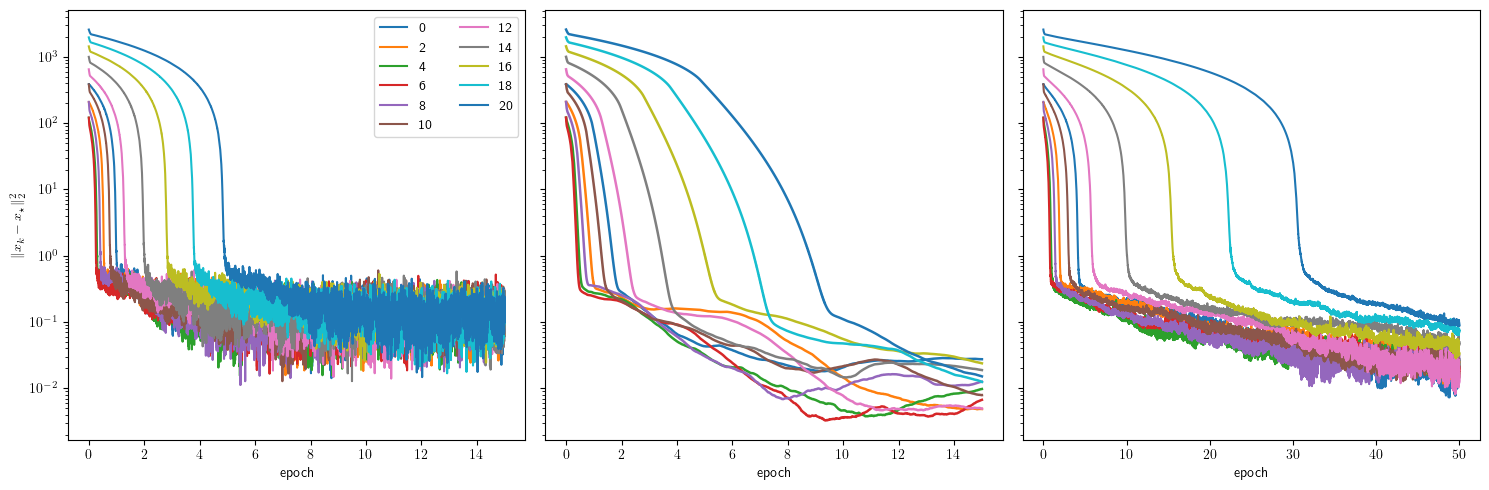

In [88]:
epochs = 15
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax1.set_yscale('log')
ax2.set_yscale('log')
for i in range(0, 21, 2):
    init_p = np.full(D+1, i)
    paramiters, paramiters_averaged = run_SGD(grad_sgd_loss, epochs, init_p, init_stepsize, stepsize_decayrate, batchsize, N)
    epochs_dec = 50
    paramiters_decreasing, _ = run_SGD(grad_sgd_loss, epochs_dec, init_p, init_stepsize, 0.2, batchsize, N)
    _ = plot_iterates_and_squared_errors_ax(paramiters, paramiters_averaged, paramiters_decreasing, true_beta, opt_param, 0, epochs, epochs_dec, N, batchsize, ax1, ax2, ax3, i) 
ax1.legend(loc="upper right", ncols=2)
# ax2.legend(loc="upper right", ncols=2)
# ax3.legend(loc="upper right", ncols=2)
ax1.set_xlabel('epoch')
ax1.set_ylabel(r'$\|x_k - x_{\star}\|_2^2$')
ax2.set_xlabel('epoch')
ax3.set_xlabel('epoch')
fig.tight_layout()

Initial Error increases from $10^2$ to $10^3$, epochs to converge go from 0 to 5, averages go from 1 to 10

The average converges more slowly than last-iteration SGD but exhibits much less noise and remains at a lower value than standard SGD. The first plot indicates that each $\beta_{i \in D}$ converges slower but more smoothly as well. Increasing the number of iterations after convergence point does not significantly decrease error since the algorithm remains constant with noise around $10^0 = 1$ error.

Step size

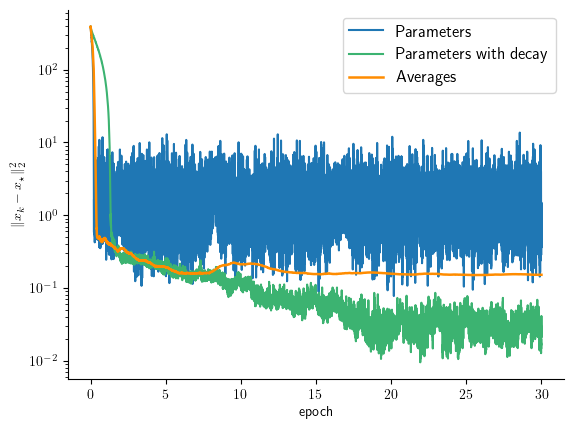

In [82]:
epochs = 30
for i in [9]:#[2, 5, 7, 9]:
    steps = i / 10
    paramiters, paramiters_averaged = run_SGD(grad_sgd_loss, epochs, init_param, steps, stepsize_decayrate, batchsize, N)
    paramiters_dec, _ = run_SGD(grad_sgd_loss, epochs, init_param, steps, 0.3, batchsize, N)
    _ = plot_iterates_and_squared_errors_dec(paramiters, paramiters_averaged, paramiters_dec, true_beta, opt_param, 0, epochs, N, batchsize) #, ax1, ax2, i) 

B

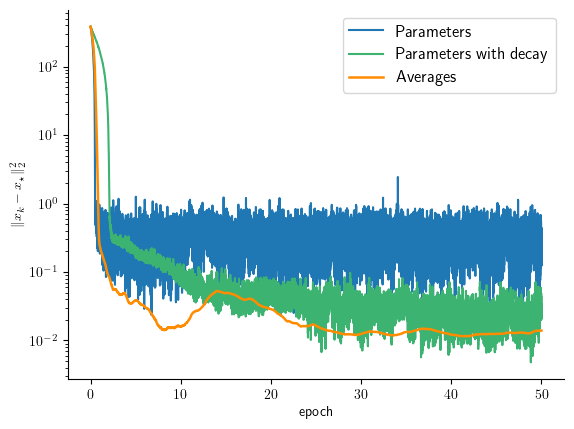

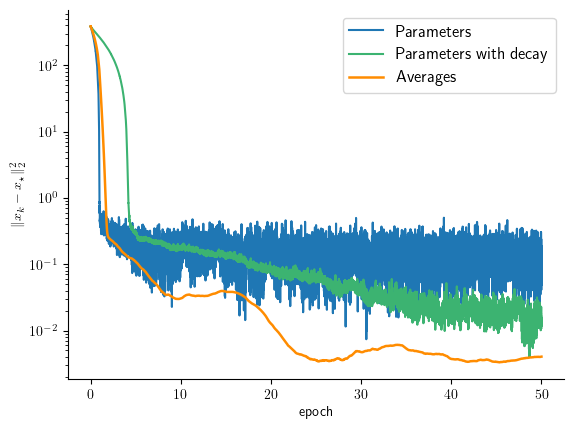

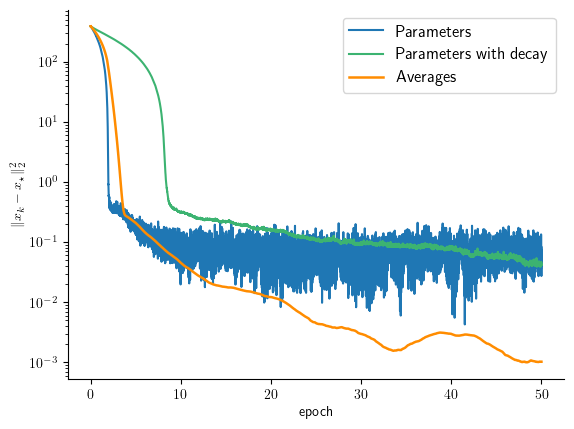

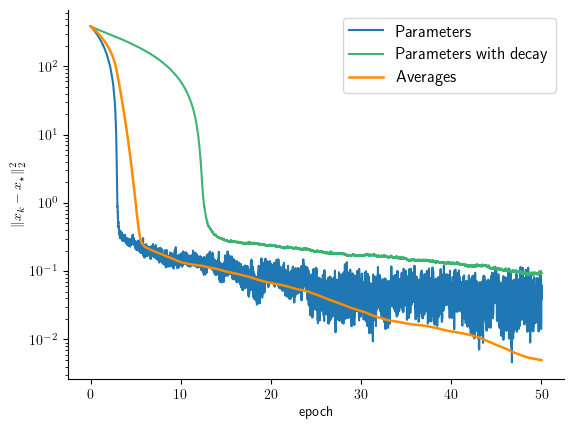

In [93]:
epochs = 50
for i in [5, 10, 20, 30]:
    paramiters, paramiters_averaged = run_SGD(grad_sgd_loss, epochs, init_param, init_stepsize, stepsize_decayrate, i, N)
    paramiters_dec, _ = run_SGD(grad_sgd_loss, epochs, init_param, init_stepsize, 0.2, i, N)
    _ = plot_iterates_and_squared_errors_dec(paramiters, paramiters_averaged, paramiters_dec, true_beta, opt_param, 0, epochs, N, i) #, ax1, ax2, i) 

Run SGD with iterate averaging starting at $\lfloor k / 2 \rfloor$.

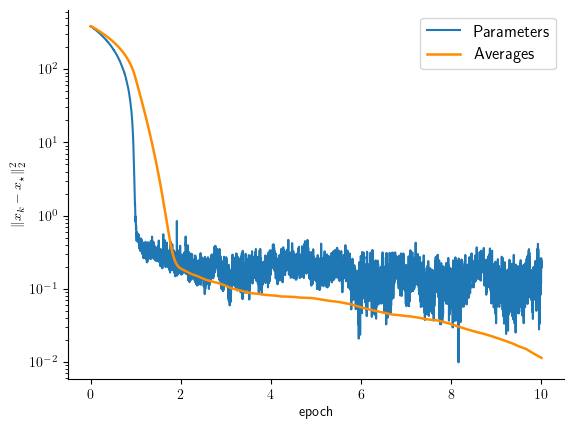

In [41]:
epochs = 10
paramiters_half, paramiters_averaged_half = run_SGD(grad_sgd_loss, epochs, init_param, init_stepsize, stepsize_decayrate, batchsize, N)
_ = plot_iterates_and_squared_errors(paramiters_half, paramiters_averaged_half, true_beta, opt_param, 0, epochs, N, batchsize, plot_first=False) 

Starting the running average at half of the iterations elliminates the initial noise from early iterates but does not seem to significantly decrease the final error. This effect is likely to bring more benefit in cases where last-iterate SGD converges more slowly, creating a stronger need to discard early iterates.

In [ ]:
print(f"Last iterate error no iterate averaging = {np.linalg.norm(paramiters[-1, :] - opt_param)}")
print(f"Last iterate error iterate averaging starting at 0 = {np.linalg.norm(paramiters_averaged[-1, :] - opt_param)}")
print(f"Last iterate error iterate averaging starting at epochs // 2 = {np.linalg.norm(paramiters_averaged_half[-1, :] - opt_param)}\n")
def spread_iters(params, eps, label):
    norms = np.linalg.norm(params[(eps * N) // batchsize:, :] - opt_param[np.newaxis,:], axis=1)
    print(f"Max{label} iterate error after {eps} epochs {norms.max()}")
    print(f"Min iterate error after {eps} epochs{label} {norms.min()}")
    print(f"Mean{label} iterate error after {eps} epochs {norms.mean()}\n")
spread_iters(paramiters, 100, "")
spread_iters(paramiters_averaged, 100, " averaged")
print()
spread_iters(paramiters, 150, "")
spread_iters(paramiters_averaged, 150, " averaged")
spread_iters(paramiters_averaged_half, 150, " averaged at half")

Last iterate error no iterate averaging = 1.1563771662646605
Last iterate error iterate averaging starting at 0 = 1.0681357068844803
Last iterate error iterate averaging starting at epochs // 2 = 1.0868340417595723

Max iterate error after 100 epochs 1.577474174129012
Min iterate error after 100 epochs 0.7607708488908901
Mean iterate error after 100 epochs 1.1439505812451378

Max averaged iterate error after 100 epochs 1.0697259011105595
Min iterate error after 100 epochs averaged 1.0596547483991963
Mean averaged iterate error after 100 epochs 1.0670709378473247


Max iterate error after 150 epochs 1.1563771662646605
Min iterate error after 150 epochs 1.1563771662646605
Mean iterate error after 150 epochs 1.1563771662646605

Max averaged iterate error after 150 epochs 1.0681357068844803
Min iterate error after 150 epochs averaged 1.0681357068844803
Mean averaged iterate error after 150 epochs 1.0681357068844803

Max averaged at half iterate error after 150 epochs 1.0868340417595723
Min

b)

In [ ]:
print(np.linalg.norm(np.zeros_like(opt_param) - opt_param))

19.6468827043885


14.044328227560708


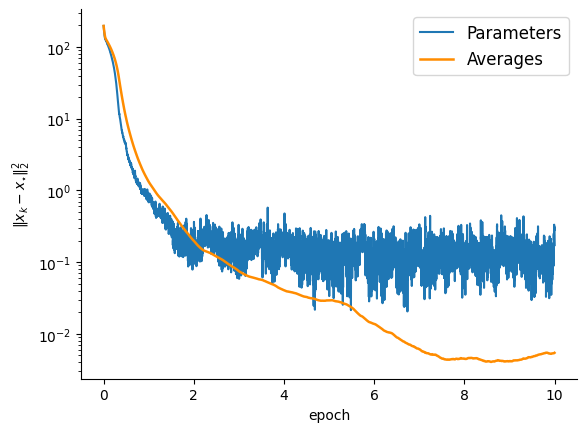

In [43]:
x0 = np.random.uniform(0, D, D+1)
print(np.linalg.norm(x0 - opt_param))
p, p_av = run_SGD(grad_sgd_loss, epochs, x0, init_stepsize, stepsize_decayrate, batchsize, N, start_averaging=0)
_ = plot_iterates_and_squared_errors(p, p_av, true_beta, opt_param, 0, epochs, N, batchsize, start_avg=0, plot_first=False), 

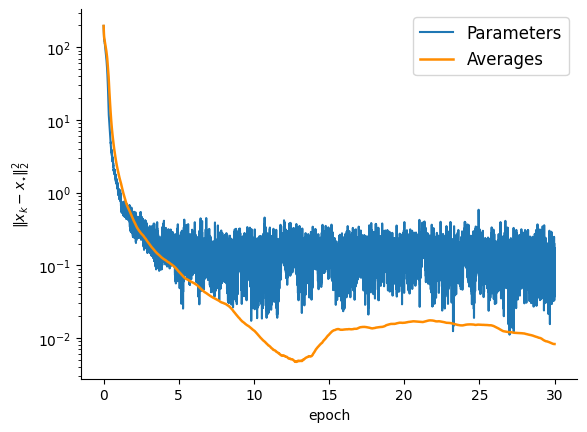

In [50]:
epochs = 30
p, p_av = run_SGD(grad_sgd_loss, epochs, x0, init_stepsize, stepsize_decayrate, batchsize, N, start_averaging=epochs // 2)
_ = plot_iterates_and_squared_errors(p, p_av, true_beta, opt_param, 0, epochs, N, batchsize, plot_first=False), 

Initializing to random uniform vector $x0 \in \mathbb{R^D}$ increases the time necessary to converge from $\approx 10$ to $\approx 100$ epochs with the same effect extending to average. The average trends upwards from $x0 = \vec{0}
$ and takes $\approx 500$ epochs tp converge. This can once again be mitigated by starting the running average at half of the iterations rather than 0.

c)

Larger constant step size.

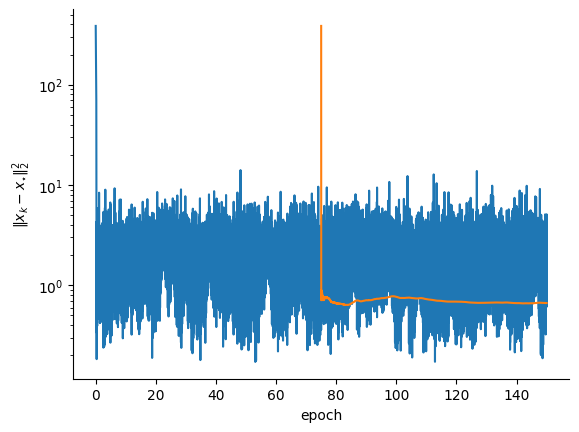

In [ ]:
stepsize = 0.8
p, p_av = run_SGD(grad_sgd_loss, epochs, init_param, stepsize, stepsize_decayrate, batchsize, N, start_averaging=epochs // 2)
_ = plot_iterates_and_squared_errors(p, p_av, true_beta, opt_param, 0, epochs, N, batchsize, start_avg=epochs // 2, plot_first=False), 

Increasing step size to larger constant value increases the noise of the algorithm, making convergence of last-iterate SGD less precise. The noise appears symmetric since the average is not affected by this change.

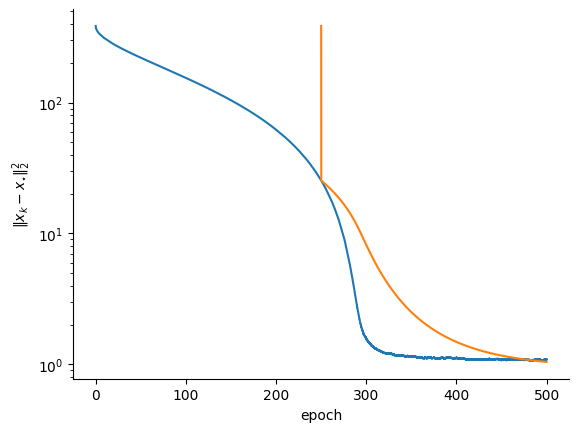

Last iterate error no iterate averaging = 1.0445007316884614
Last iterate error iterate averaging = 1.0212531904179258


In [ ]:
epochs=500
p, p_av = run_SGD(grad_sgd_loss, epochs, init_param, init_stepsize, stepsize_decayrate_alpha, batchsize, N, start_averaging=epochs // 2)
_ = plot_iterates_and_squared_errors(p, p_av, true_beta, opt_param, 0, epochs, N, batchsize, start_avg=epochs // 2, plot_first=False), 
print(f"Last iterate error no iterate averaging = {np.linalg.norm(p[-1, :] - opt_param)}")
print(f"Last iterate error iterate averaging = {np.linalg.norm(p_av[-1, :] - opt_param)}")


Running SGD with initial step size of 0.3 and step size decay rate of 0.51 causes the algorithm to converge much slower than for SGD with constant step size. After 1500 epochs (rather than 800), the algorithm produces a squared error of 4.50 - significantly higher than with constant step size. The algorithm seems to "stall out" due to step size decay and converge too slowly to achieve optimal error levels. Last-iterate SGD becomes smooth due to stepsize decay.

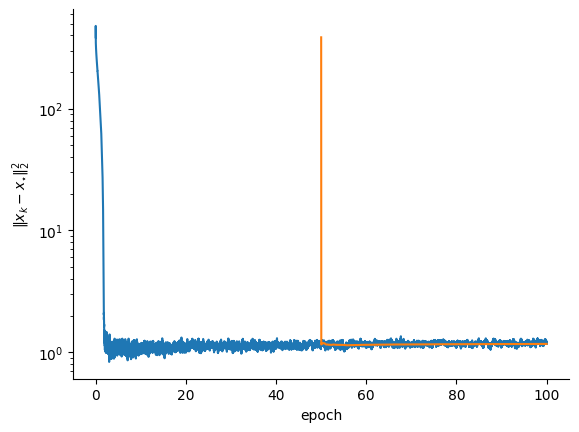

Last iterate error no iterate averaging = 1.082133505258746
Last iterate error iterate averaging = 1.0811749947679117


In [ ]:
epochs = 100
stepsize = 2.5
p, p_av = run_SGD(grad_sgd_loss, epochs, init_param, stepsize, stepsize_decayrate_alpha, batchsize, N, start_averaging=epochs // 2)
_ = plot_iterates_and_squared_errors(p, p_av, true_beta, opt_param, 0, epochs, N, batchsize, start_avg=epochs // 2, plot_first=False), 
print(f"Last iterate error no iterate averaging = {np.linalg.norm(p[-1, :] - opt_param)}")
print(f"Last iterate error iterate averaging = {np.linalg.norm(p_av[-1, :] - opt_param)}")


With stepsize decay, SGD is able to handle initial step size much larger than before (2.5 instead of 0.8 or 0.3). At 1500 epochs, the algorithm achieves error levels that are still higher than constant stepsize SGD but much more optimal than SGD with stepsize decay and smaller initial stepsize. Choosing larger stepsize allows SGD to converge fast-enough to not be stalled by stepsize decay with less noise than constant stepsize SGD.

d)

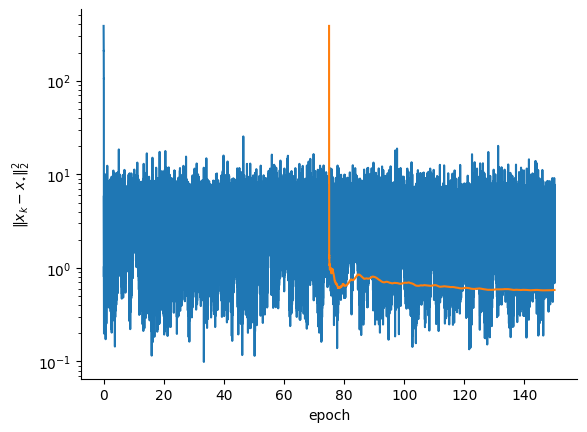

Last iterate error no iterate averaging = 1.179550493699644
Last iterate error iterate averaging = 0.7620163753208588


In [ ]:
epochs = 150
batchsize_d = batchsize // 10    # B = 1
p, p_av = run_SGD(grad_sgd_loss, epochs, init_param, init_stepsize, stepsize_decayrate, batchsize_d, N, start_averaging=epochs // 2)
_ = plot_iterates_and_squared_errors(p, p_av, true_beta, opt_param, 0, epochs, N, batchsize_d, start_avg=epochs // 2, plot_first=False), 
print(f"Last iterate error no iterate averaging = {np.linalg.norm(p[-1, :] - opt_param)}")
print(f"Last iterate error iterate averaging = {np.linalg.norm(p_av[-1, :] - opt_param)}")

Decreasing batchsize to 1 intruduces significantly more noise into the algorithm, making convergence without averaging very approximate. With averaging, the algorithm still achieves error levels comparable to batchsize of 10. Decreasing batchsize also increased the execution time from 56 seconds to 5 min 13 seconds $(\approx 5.5 \text{ times})$.

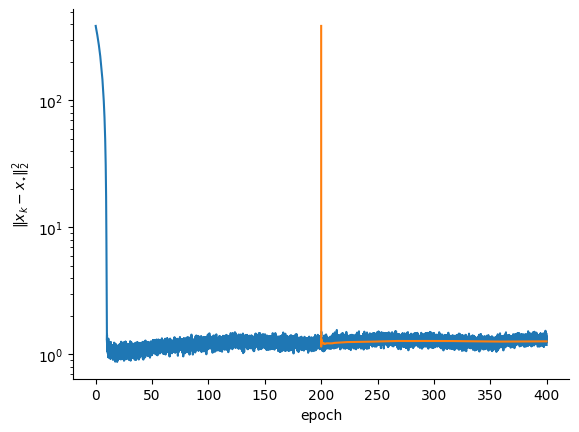

Last iterate error no iterate averaging = 1.0886900641517878
Last iterate error iterate averaging = 1.1250862165735944


In [ ]:
epochs = 400
batchsize_d = 100
p, p_av = run_SGD(grad_sgd_loss, epochs, init_param, init_stepsize, stepsize_decayrate, batchsize_d, N, start_averaging=epochs // 2)
_ = plot_iterates_and_squared_errors(p, p_av, true_beta, opt_param, 0, epochs, N, batchsize_d, start_avg=epochs // 2, plot_first=False), 
print(f"Last iterate error no iterate averaging = {np.linalg.norm(p[-1, :] - opt_param)}")
print(f"Last iterate error iterate averaging = {np.linalg.norm(p_av[-1, :] - opt_param)}")


Increasing batchsize allows us to run the algorithm for much larger number of epochs (5000) in $\approx 19$ seconds. However, the algorithm converges much slowly, taking $\approx 1000$ epoch to reach levels of error that $B=10$ SGD sees at 30-50 epochs. After 5000 epochs, error levels are comparable, indicating that larger batchsize SGD allows for processing more data with "rougher" regression.

e)

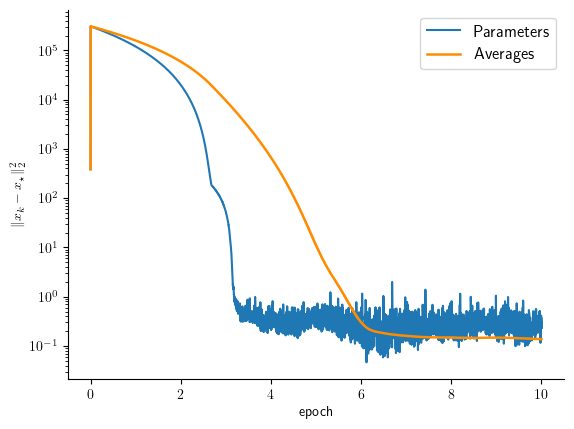

Last iterate error no iterate averaging = 0.5475406595011518
Last iterate error iterate averaging = 0.3708776686540877


In [54]:
std_reg_loss, grad_std_reg_loss = make_sgd_robust_loss(Y, Z, np.inf)
epochs = 10
p, p_av = run_SGD(grad_std_reg_loss, epochs, init_param, init_stepsize, stepsize_decayrate, batchsize, N, start_averaging=epochs // 2)
_ = plot_iterates_and_squared_errors(p, p_av, true_beta, opt_param, 0, epochs, N, batchsize, plot_first=False)
print(f"Last iterate error no iterate averaging = {np.linalg.norm(p[-1, :] - opt_param)}")
print(f"Last iterate error iterate averaging = {np.linalg.norm(p_av[-1, :] - opt_param)}")

Changing loss to standard regression loss with $\nu = \infty$ causes a large initial jump followed by convergence at similar rate but to lower final error. Since this is a different loss function, it's not entirely clear if the final loss can be compared directly but the algorithm seems to perform slightly better with $\nu = \infty$ loss rather than $\nu = 5$.

In [86]:
def plot_iterates_and_squared_errors_ax(paramiters, paramiters_averaged, param_dec, true_beta, opt_param, skip_epochs, epochs, epochs_dec, N, batchsize, ax1, ax2, ax3, i, include_psi=True):
    D = true_beta.size
    param_names = [r'$\beta_{{{}}}$'.format(i) for i in range(D)]
    if include_psi:
        param_names = [r'$\psi$'] + param_names
    else:
        paramiters = paramiters[:,1:]
        opt_param = opt_param[1:]
    skip_epochs = 0
    skip_iters = int(skip_epochs*N//batchsize)
    xs = np.linspace(skip_epochs, epochs, paramiters.shape[0] - skip_iters)
    xss = np.linspace(skip_epochs, epochs_dec, param_dec.shape[0] - skip_iters)
    ax1.plot(xs, np.linalg.norm(paramiters - opt_param[np.newaxis,:], axis=1)**2, label=f"{i}")
    ax2.plot(xs, np.linalg.norm(paramiters_averaged - opt_param[np.newaxis:], axis=1)**2, linewidth=1.8, label=f"{i}")
    ax3.plot(xss, np.linalg.norm(param_dec - opt_param[np.newaxis:], axis=1)**2, label=f"{i}")


In [69]:
def plot_iterates_and_squared_errors_dec(paramiters, paramiters_averaged, paramiters_decreasing, true_beta, opt_param, skip_epochs, epochs, N, batchsize, include_psi=True):
    D = true_beta.size
    param_names = [r'$\beta_{{{}}}$'.format(i) for i in range(D)]
    if include_psi:
        param_names = [r'$\psi$'] + param_names
    else:
        paramiters = paramiters[:,1:]
        opt_param = opt_param[1:]
    skip_epochs = 0
    skip_iters = int(skip_epochs*N//batchsize)
    xs = np.linspace(skip_epochs, epochs, paramiters.shape[0] - skip_iters)
    plt.plot(xs, np.linalg.norm(paramiters - opt_param[np.newaxis,:], axis=1)**2, label="Parameters")
    plt.plot(xs, np.linalg.norm(paramiters_decreasing - opt_param[np.newaxis:], axis=1)**2, label="Parameters with decay", color="mediumseagreen")
    plt.plot(xs, np.linalg.norm(paramiters_averaged - opt_param[np.newaxis:], axis=1)**2, color="darkorange", linewidth=1.8, label="Averages")
    plt.legend(loc="upper right", fontsize=12)
    plt.xlabel('epoch')
    plt.ylabel(r'$\|x_k - x_{\star}\|_2^2$')
    plt.yscale('log')
    sns.despine()
    plt.show()
